# Production demand forecasting

In the manufacturing industries. We will frequently recieved unpredictable order from the customers. Presently, There are a lot 
of technic to forecast production demand. 
The benefit of forecasting is helping the entrepreneur make decision in bussiness.

In [90]:
import numpy as np
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import statsmodels.api as sm
from datetime import datetime

In [40]:
df = pd.read_csv("Historical Product Demand.csv",parse_dates=True)

## Explore data

In [41]:
df.head()

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,Product_0993,Whse_J,Category_028,2012/7/27,100
1,Product_0979,Whse_J,Category_028,2012/1/19,500
2,Product_0979,Whse_J,Category_028,2012/2/3,500
3,Product_0979,Whse_J,Category_028,2012/2/9,500
4,Product_0979,Whse_J,Category_028,2012/3/2,500


In [42]:
df.tail()

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
1048570,Product_1791,Whse_J,Category_006,2016/4/27,1000
1048571,Product_1974,Whse_J,Category_006,2016/4/27,1
1048572,Product_1787,Whse_J,Category_006,2016/4/28,2500
1048573,Product_0901,Whse_J,Category_023,2016/10/7,50
1048574,Product_0704,Whse_J,Category_001,2016/6/27,4


In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 5 columns):
 #   Column            Non-Null Count    Dtype 
---  ------            --------------    ----- 
 0   Product_Code      1048575 non-null  object
 1   Warehouse         1048575 non-null  object
 2   Product_Category  1048575 non-null  object
 3   Date              1037336 non-null  object
 4   Order_Demand      1048575 non-null  object
dtypes: object(5)
memory usage: 40.0+ MB


In [44]:
## Check number of Null
df.isnull().sum()

Product_Code            0
Warehouse               0
Product_Category        0
Date                11239
Order_Demand            0
dtype: int64

In [45]:
## Drop Null data row axis
df.dropna(axis=0,inplace=True)

In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1037336 entries, 0 to 1048574
Data columns (total 5 columns):
 #   Column            Non-Null Count    Dtype 
---  ------            --------------    ----- 
 0   Product_Code      1037336 non-null  object
 1   Warehouse         1037336 non-null  object
 2   Product_Category  1037336 non-null  object
 3   Date              1037336 non-null  object
 4   Order_Demand      1037336 non-null  object
dtypes: object(5)
memory usage: 47.5+ MB


In [47]:
## Transform Date column to datetime index
df['Date'] = pd.to_datetime(df['Date'])

In [48]:
df.set_index('Date',inplace=True)

In [49]:
df.head()

,Product_Code,Warehouse,Product_Category,Order_Demand
Date,,,,
2012-07-27,Product_0993,Whse_J,Category_028,100
2012-01-19,Product_0979,Whse_J,Category_028,500
2012-02-03,Product_0979,Whse_J,Category_028,500
2012-02-09,Product_0979,Whse_J,Category_028,500
2012-03-02,Product_0979,Whse_J,Category_028,500


In [50]:
# pd.to_numeric(df['Order_Demand']) ### Error due to assest in cell data include "()" 
import re
## Create Function to fill numerical
def cleanStr(inputs):
    return re.sub("[^0-9]","",inputs)
df['Order_Demand'] = pd.to_numeric(df['Order_Demand'].apply(cleanStr))

## Visualization data

The visualization data is important process to explore Data behavior or data charatersitic by Visualization


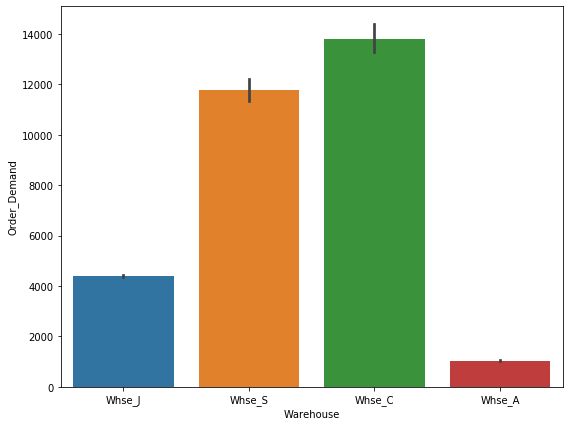

In [51]:
plt.figure(figsize=(9,7))
sns.barplot(x=df['Warehouse'],y=df['Order_Demand'])
# df[['Warehouse','Order_Demand']].groupby('Warehouse').sum()

The above picture shown the production volumes for each Factory which is imbalanced order. this problem is undefine what's going on. So we decide to forecast with sum of volume

In [52]:
order_df = df['Order_Demand'].groupby('Date').sum()

in the term forecasting in factory we will forecast the max order for each month. Due to the process capability is difficult to increase promptly.
In this case, The management team should know the trend of max volume in the future

In [53]:
## Resample to correct max of each start month
order_df = order_df.resample('MS').max()

In [54]:
## Repalce NaN cell with 0
order_df = order_df.fillna(0)

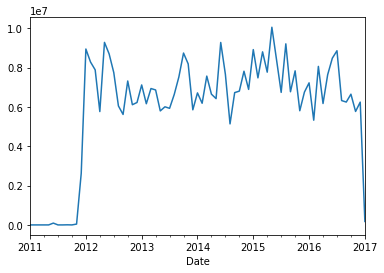

In [55]:
order_df.plot()

in the picture above. We decide to drop out **2011** 

Text(0.5, 1.0, 'Order from customer each years')

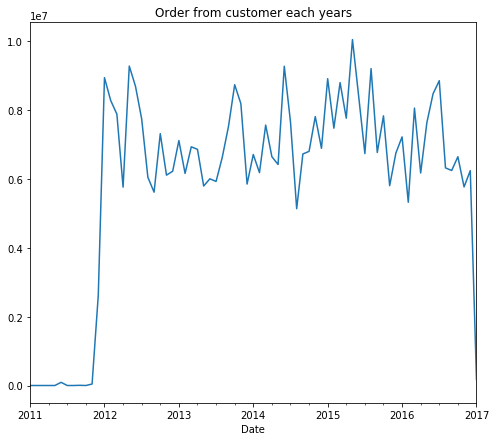

In [56]:
plt.figure(figsize=(8,7))
order_df.plot()
plt.title("Order from customer each years")

In [57]:
order_df_2012_2016 = order_df['2012':'2016']

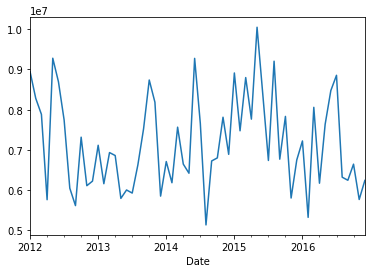

In [58]:
order_df_2012_2016.plot()

## Arima Model

Theory on ARIMA

An ARIMA model is characterized by 3 terms: p, d, q where these three parameters account for seasonality (p), trend (d), and noise in data (q):

* p is the order of the AR term (number of lags of Y to be used as predictors). If it snowed for the last wee, it is likely it will snow tomorrow.
* q is the order of the MA term (moving average).
* d is the number of differencing required to make the time series stationary. if already stationary d=0.

But when dealing with SEASONALITY, it is best to incorporate it as 's'. ARIMA(p,d,q)(P,D,Q)s. Where 'pdq' are non seasonal params and 's' is the perdiocity of the time series. 4:quarter, 12:yearly etc.
If a time series, has seasonal patterns, then you need to add seasonal terms and it becomes SARIMA, short for ‘Seasonal ARIMA’.

In [59]:
from statsmodels.tsa.seasonal import seasonal_decompose

decompose = seasonal_decompose(order_df_2012_2016)

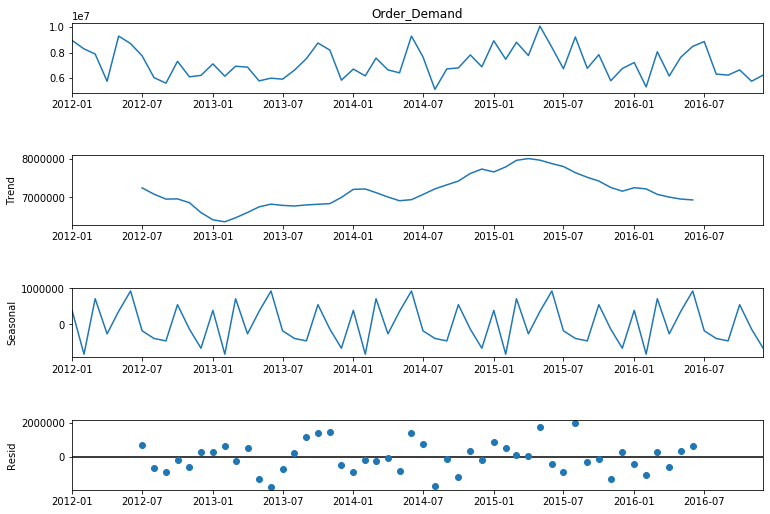

In [60]:
fig = decompose.plot()
fig.set_size_inches(12,8)

## Finding Is model a stationary

The Stationary is the pattern of time series doesn't change variance and std relate the time.
This hypotysis is proved by p-value 

In [61]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(order_df)
if result[1] <= 0.05:
    print(f"Accept Hypotysis with p-value: {result[1]}")
else:
    print(f"Reject Hypotysis with p-value: {result[1]}")

Reject Hypotysis with p-value: 0.05228252529847156


In [62]:
diff_1 = order_df_2012_2016.diff(1)

In [63]:
result = adfuller(diff_1.dropna())
if result[1] <= 0.05:
    print(f"Accept Hypotysis with p-value: {result[1]}")
else:
    print(f"Reject Hypotysis with p-value: {result[1]}")

Accept Hypotysis with p-value: 9.589022393011419e-05


C:\Users\n_int\AppData\Roaming\Python\Python37\site-packages\statsmodels\graphics\tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


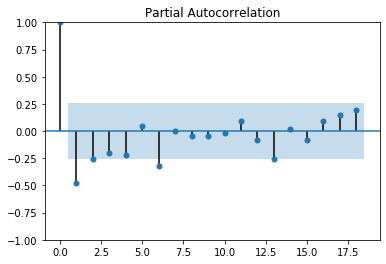

In [64]:
from statsmodels.graphics.tsaplots import  plot_pacf
fig = plot_pacf(diff_1.dropna())

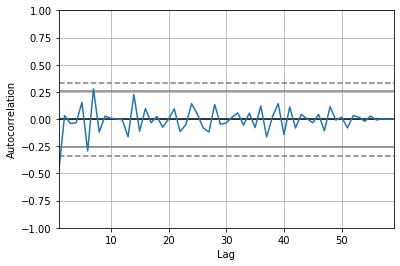

In [65]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(diff_1.dropna())
plt.show()

In [66]:
from statsmodels.tsa.arima.model import ARIMA
p=q=d = range(0,4)
pdq = list(itertools.product(p,d,q))
aic_results = []
params = []
for param in pdq:
    model = ARIMA(order_df_2012_2016, order=param)
    results = model.fit()
    aic_results.append(results.aic)
    params.append(param)

C:\Users\n_int\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\n_int\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\n_int\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\n_int\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters 

In [67]:
np.argmin(aic_results)

47

In [68]:
params[47]

(2, 3, 3)

## Fit Model with the best parameter

In [142]:
model = ARIMA(order_df,order=(2,3,3))
final_result = model.fit()

C:\Users\n_int\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [143]:
final_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           Order_Demand   No. Observations:                   73
Model:                 ARIMA(2, 3, 3)   Log Likelihood               -1109.651
Date:                Fri, 15 Oct 2021   AIC                           2231.302
Time:                        23:00:29   BIC                           2244.793
Sample:                    01-01-2011   HQIC                          2236.661
                         - 01-01-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.1648      0.587     -1.986      0.047      -2.314      -0.015
ar.L2         -0.3055      0.206     -1.486      0.137      -0.709       0.098
ma.L1         -1.0629      0.632     -1.681      0.093      -2.302       0.176
ma.L2         -0.7393      1.113     -0.664      0.506      -2.920       1.442
ma.L3          0.8120      0.588      1.382      0.167      -0.340       1.964
sigma2      4.588e+12   5.03e-13   9.13e+24      0.000    4.59e+12    4.59e+12
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                13.34
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):               0.82   Skew:                            -0.09
Prob(H) (two-sided):                  0.63   Kurtosis:                         5.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.34e+40. Standard errors may be unstable.
"""

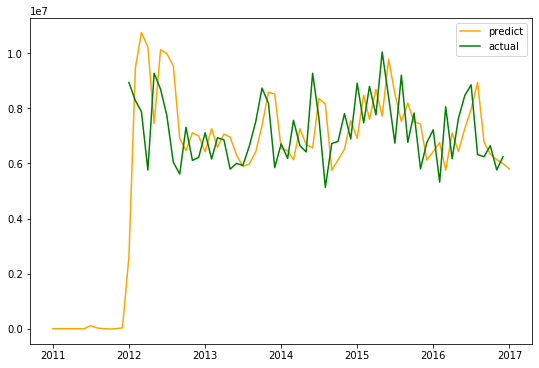

In [144]:
## Plot Comparision prediction 

plt.figure(figsize=(9,6))
plt.plot(final_result.predict(),color='orange',label="predict")
plt.plot(order_df_2012_2016,color='green',label='actual')
plt.legend()

In [146]:
fig = results.plot_diagnostics(figsize = (11,7))

In [85]:
start = datetime(2017,1,1)
end = datetime(2017,12,1)
forecast_12 = results.predict(start=start,end=end)

In [87]:
forecast_12

2017-01-01    6.086322e+06
2017-02-01    5.911765e+06
2017-03-01    5.974357e+06
2017-04-01    5.701383e+06
2017-05-01    5.798268e+06
2017-06-01    5.506933e+06
2017-07-01    5.605976e+06
2017-08-01    5.309476e+06
2017-09-01    5.405297e+06
2017-10-01    5.105829e+06
2017-11-01    5.197530e+06
2017-12-01    4.895459e+06
Freq: MS, Name: predicted_mean, dtype: float64

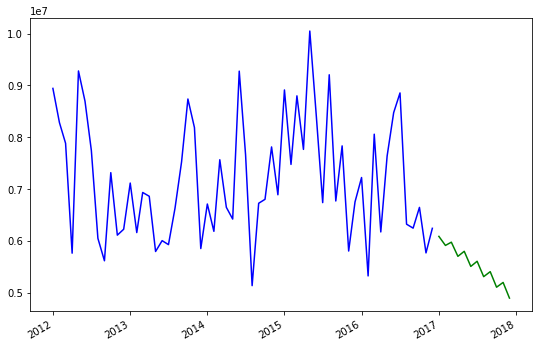

In [147]:
plt.figure(figsize=(9,6))
plt.plot(order_df_2012_2016,color='blue')
forecast_12.plot(color='green')

In [111]:
p=q=d = range(0,3)
seasonal_order = []
for i,j,k in pdq:
    seasonal_order.append((i,j,k,12))

## Prediction with SARIMA

In [141]:
aic_results = []
params = []
for param in pdq:
    for season_param in seasonal_order:
        model_sa = sm.tsa.statespace.SARIMAX(order_df,order=param,seasonal_order=season_param,enforce_stationarity=False,
                                            enforce_invertibility=False)
        results = model_sa.fit()
        aic_results.append(results.aic)
        params.append((param,season_param))

In [132]:
aic_results

[2033.3153153427572,
 1594.2987750367306,
 1422.6244405847756,
 721.1185595499877,
 1486.2726958457577,
 3326.986505875461,
 722.3997418529648,
 345.80140672871784,
 1153.504351059914,
 745.8614562565151,
 355.1459062485423,
 8.0,
 2191.950483652128,
 455.8164499170365,
 6.0,
 8.0,
 1517.1463165052378,
 1483.3732804723966,
 1090.7183369261597,
 721.0102744311464,
 1121.2036367677686,
 3123.810673093137,
 722.9500167488778,
 347.25149944647177,
 776.9735532126983,
 745.203434236178,
 356.7324897838251,
 10.0,
 396.23269254562524,
 367.51617167321183,
 8.0,
 10.0,
 1123.0755859821616,
 1123.135322325008,
 1089.8083123483545,
 720.4909159956378,
 748.0978155123507,
 2092.6922259707753,
 723.070670833156,
 349.2514993572154,
 371.5496211714523,
 388.94970486708706,
 358.7316158910334,
 12.0,
 6.0,
 8.0,
 10.0,
 12.0,
 748.4131609335534,
 748.5526383379477,
 750.2309216787866,
 722.4909143256041,
 367.2228007963563,
 1081.2077678719675,
 379.94585490844855,
 351.25149932953866,
 8.0,
 10.0,

In [115]:
params[14]

((0, 0, 0), (0, 3, 2, 12))

In [138]:
# model_sa_final = sm.tsa.statespace.SARIMAX(order_df,order=(1,1,1),seasonal_order=(1, 1, 0, 12))
model_sa_final = sm.tsa.statespace.SARIMAX(order_df,order=(0,0,0),seasonal_order=(0, 3, 2, 12))
results_sa = model_sa.fit()

C:\Users\n_int\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\statespace\sarimax.py:868: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  ' zeros.' % warning_description)


In [139]:
results_sa.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    SARIMAX Results                                     
========================================================================================
Dep. Variable:                     Order_Demand   No. Observations:                   73
Model:             SARIMAX(1, 1, [1, 2, 3], 12)   Log Likelihood                -387.265
Date:                          Fri, 15 Oct 2021   AIC                            784.531
Time:                                  22:59:33   BIC                            790.421
Sample:                              01-01-2011   HQIC                           786.094
                                   - 01-01-2017                                         
Covariance Type:                            opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.5088      3.196     -0.159      0.874      -6.773       5.756
ma.S.L12       0.1034      4.001      0.026      0.979      -7.738       7.945
ma.S.L24      -0.2865      0.754     -0.380      0.704      -1.763       1.190
ma.S.L36       0.1266      0.863      0.147      0.883      -1.565       1.818
sigma2      1.156e+13   1.48e-12   7.81e+24      0.000    1.16e+13    1.16e+13
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):                37.14
Prob(Q):                              0.83   Prob(JB):                         0.00
Heteroskedasticity (H):               3.10   Skew:                            -1.56
Prob(H) (two-sided):                  0.13   Kurtosis:                         8.24
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.66e+41. Standard errors may be unstable.
"""

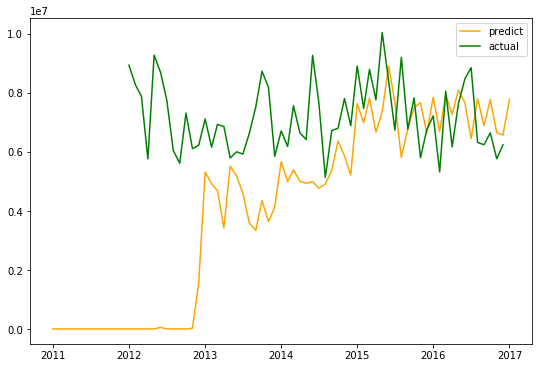

In [140]:
## Plot Comparision prediction 

plt.figure(figsize=(9,6))
plt.plot(results_sa.predict(),color='orange',label="predict")
plt.plot(order_df_2012_2016,color='green',label='actual')
plt.legend()

In [148]:
start = datetime(2017,1,1)
end = datetime(2017,12,1)
forecast_12 = results_sa.predict(start=start,end=end)

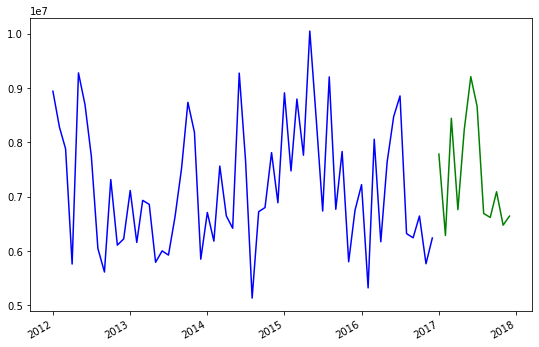

In [150]:
plt.figure(figsize=(9,6))
plt.plot(order_df_2012_2016,color='blue')
forecast_12.plot(color='green')